<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/148b_Handling_Imbalanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/91n4mzfgMqA

# Handling Imbalanced Data in Marketing: A Business-Focused Approach
## Real Bank Marketing Campaign Analysis

### Problem Statement:
Using a real bank marketing dataset (45,211 customers, 11.7% subscription rate), we'll explore different approaches to handling class imbalance through a business lens. This tutorial demonstrates how to choose the right technique based on your specific business context and costs.

### What We'll Explore:
1. **Real Business Imbalance**: 88.3% no subscription vs 11.7% subscription (realistic marketing scenario)
2. **Multiple Approaches**: SMOTE oversampling, class weights, threshold tuning, and cost optimization
3. **Business Trade-offs**: Subscription detection vs marketing efficiency
4. **Decision Framework**: Choosing methods based on actual business costs, not just statistical metrics

### The Business Context:
In marketing campaigns, every decision has real financial impact. FOr example, if...
- **Customer lifetime value**: \$200 per term deposit subscriber
- **Marketing cost**: \$10 per contact (call/email)
- **The trade-off**: When is it worth contacting more prospects to find subscribers?

### Key Questions We'll Answer:
- How do different imbalance handling methods affect business outcomes?
- When should you prioritize finding more subscribers vs minimizing marketing waste?
- How do you balance statistical performance with business costs?
- Which approach works best when missing a customer costs 20x more than a wasted contact?

### Why This Matters:
Real marketing campaigns must balance multiple objectives. This tutorial provides a practical framework for evaluating imbalance handling techniques based on your specific business context, costs, and constraints rather than just academic metrics.

The methods we compare will show quite different trade-offs between finding subscribers and controlling marketing costs, helping you understand which approach fits your business situation.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


### Bank Marketing Dataset Analysis

Working with a real bank marketing dataset from Portuguese telemarketing campaigns - 45,211 customer
contacts with 11.7% subscription rate for term deposits. This represents a realistic business
imbalance where positive outcomes are naturally rare.

The dataset contains 16 features including customer demographics (age, job, education), campaign
details (contact method, duration), and economic indicators. The 7.5:1 class imbalance makes this
perfect for testing imbalance handling techniques.

Training: 36,168 samples (4,231 subscriptions)
Testing: 9,043 samples (1,058 subscriptions)

The PCA visualization reveals interesting customer patterns - subscription cases form distinct
clusters suggesting identifiable customer segments willing to subscribe. This real-world
complexity makes it an ideal testbed for our approaches.

In [ ]:
# ===============================================
# PART 1: LOAD BANK MARKETING DATASET
# ===============================================

# Dataset: Bank Marketing Data Set
# Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
# Citation: Moro et al., A Data-Driven Approach to Predict the Success of Bank Telemarketing (2014)

def load_bank_marketing_dataset():
    """
    Load and preprocess the Bank Marketing dataset for term deposit subscription prediction

    Returns:
    X, y, feature_names for bank marketing classification
    """
    # Load the dataset
    df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/bank-full.csv', sep=';')

    print(f"Dataset shape: {df.shape}")

    # Prepare features and target
    X_df = df.drop(columns=['y'])
    y_series = df['y']

    # Convert target to binary (1 for 'yes', 0 for 'no')
    y = (y_series == 'yes').astype(int)

    print(f"Target distribution:")
    print(f"No subscription (0): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
    print(f"Subscription (1): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")

    # Handle categorical variables with label encoding
    from sklearn.preprocessing import LabelEncoder

    X_processed = X_df.copy()
    categorical_columns = X_df.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_df[col])

    X = X_processed.values
    feature_names = X_processed.columns.tolist()

    return X, y, feature_names

# Load the Bank Marketing dataset
print("Loading Bank Marketing dataset...")
X, y, feature_names = load_bank_marketing_dataset()
print(f"Loaded dataset: {len(y)} samples with {len(feature_names)} features")

print(f"\nDataset characteristics:")
print(f"Total samples: {len(y):,}")
print(f"Features: {X.shape[1]}")
print(f"No subscription: {sum(y == 0):,} ({sum(y == 0)/len(y)*100:.3f}%)")
print(f"Subscription: {sum(y == 1):,} ({sum(y == 1)/len(y)*100:.3f}%)")
print("This represents realistic bank marketing campaign scenario\n")

# Split the data - use larger test set for more reliable evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ensure we have numpy arrays (not pandas series)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Training subscription cases: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.3f}%)")
print(f"Test subscription cases: {sum(y_test == 1):,} ({sum(y_test == 1)/len(y_test)*100:.3f}%)\n")

Loading Bank Marketing dataset...
Dataset shape: (45211, 17)
Target distribution:
No subscription (0): 39922 (88.3%)
Subscription (1): 5289 (11.7%)
Loaded dataset: 45211 samples with 16 features

Dataset characteristics:
Total samples: 45,211
Features: 16
No subscription: 39,922 (88.302%)
Subscription: 5,289 (11.698%)
This represents realistic bank marketing campaign scenario

Training set: 36,168 samples
Test set: 9,043 samples
Training subscription cases: 4,231 (11.698%)
Test subscription cases: 1,058 (11.700%)



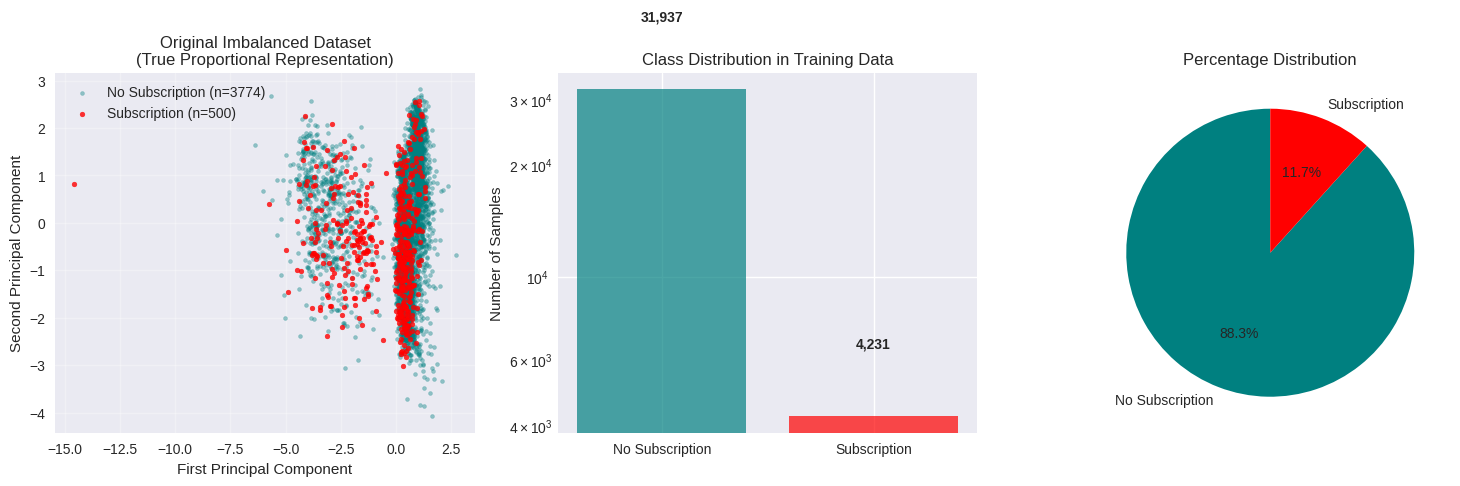

In [ ]:
# ===============================================
# PART 2: VISUALIZE THE IMBALANCE
# ===============================================

# Create visualization using PCA t
pca = PCA(n_components=2, random_state=42)

# Let us not plot all data points but a subset, for better visualization
# For visualization, maintain the actual proportional representation
positive_indices = np.where(y_train == 1)[0]  # Bank subscription cases
negative_indices = np.where(y_train == 0)[0]  # No subscription cases

# Sample proportionally to maintain the true 88:12 ratio in visualization
# If we show 500 subscription cases, we should show ~3750 no-subscription cases to maintain ratio
n_subscription_show = 500  # Reasonable number to see patterns
n_no_subscription_show = int(n_subscription_show * (len(negative_indices) / len(positive_indices)))  # ~3750

# Random sample maintaining proportions
viz_subscription_indices = np.random.choice(positive_indices, size=min(n_subscription_show, len(positive_indices)), replace=False)
viz_no_subscription_indices = np.random.choice(negative_indices, size=min(n_no_subscription_show, len(negative_indices)), replace=False)
viz_indices = np.concatenate([viz_no_subscription_indices, viz_subscription_indices])

X_viz = X_train_scaled[viz_indices]
y_viz = y_train[viz_indices]

X_viz_pca = pca.fit_transform(X_viz)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
colors = ['teal', 'red']
labels = ['No Subscription', 'Subscription']
sizes = [8, 12]     # Smaller sizes, subscription slightly larger but not overwhelming

for i, (color, label, size) in enumerate(zip(colors, labels, sizes)):
    mask = y_viz == i
    alpha = 0.8 if i == 1 else 0.4  # Make subscription points more visible but not dominant
    plt.scatter(X_viz_pca[mask, 0], X_viz_pca[mask, 1],
               c=color, alpha=alpha, s=size, label=f'{label} (n={sum(mask)})')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Original Imbalanced Dataset\n(True Proportional Representation)')
plt.legend()
plt.grid(True, alpha=0.3)

# Show class distribution
plt.subplot(1, 3, 2)
class_counts = [sum(y_train == 0), sum(y_train == 1)]
plt.bar(['No Subscription', 'Subscription'], class_counts, color=['teal', 'red'], alpha=0.7)
plt.title('Class Distribution in Training Data')
plt.ylabel('Number of Samples')
plt.yscale('log')  # Log scale to see the subscription cases
for i, count in enumerate(class_counts):
    plt.text(i, count * 1.5, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Show percentage
plt.subplot(1, 3, 3)
percentages = [sum(y_train == 0)/len(y_train)*100, sum(y_train == 1)/len(y_train)*100]
plt.pie(percentages, labels=['No Subscription', 'Subscription'], colors=['teal', 'red'],
        autopct='%1.1f%%', startangle=90)
plt.title('Percentage Distribution')

plt.tight_layout()
plt.show()


### Baseline XGBoost: Surprisingly Decent Performance

**The results we will see:**

- **Predicted subscriptions (744):** This is 254 (false positives) + 490 (true positives) = 744 total predictions of "subscription"

- **Actually subscription (1058):** This is 568 (false negatives) + 490 (true positives) = 1,058 people who actually subscribed

- **Actually NO subscription (7985):** This is 7731 (true negatives) + 254 (false positives) = 7,985 people who actually didn't subscribe

Unlike extreme imbalanced scenarios, this real marketing data shows XGBoost handles moderate
imbalance reasonably well:
- 54.4% F1-score, 46.3% subscription detection rate
- 254 wasted marketing efforts out of 9,043 customers
- Catches 490 out of 1,058 potential subscribers

**What this means in business terms:**
- **Wasted marketing efforts**: The model predicted 744 customers would subscribe, but only 490 actually did. The other 254 customers received marketing calls/emails but said "no" - that's wasted time and money on uninterested prospects.
- **Missed subscriptions**: Out of 1,058 customers who would actually subscribe if contacted, the model only identified 490 of them. The remaining 568 customers wanted the product but never got contacted - that's lost revenue.

The baseline shows typical imbalanced data bias - high precision (65.9%) but lower recall (46.3%).
This conservative approach minimizes marketing waste but misses significant revenue opportunities.
In simple terms: the model is very careful about who it recommends contacting (high precision) but
misses many good prospects in the process (low recall).

Note that real business data often has learnable patterns that basic XGBoost can detect, unlike synthetic datasets where baseline performance is catastrophic. So work with real data, when possible.

In [ ]:
# ===============================================
# PART 3: BASELINE MODEL PERFORMANCE
# ===============================================

print("=== BASELINE MODEL: No Imbalance Handling ===")

# Train baseline XGBoost model
baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    verbosity=0,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1
)

baseline_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_prob_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Comprehensive metrics function
def calculate_metrics(y_true, y_pred, y_prob, model_name):
    """
    Calculate all relevant metrics for imbalanced classification
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

    metrics = {}
    metrics['Model'] = model_name
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1_Score'] = f1_score(y_true, y_pred)
    metrics['ROC_AUC'] = roc_auc_score(y_true, y_prob)
    metrics['PR_AUC'] = average_precision_score(y_true, y_prob)

    # Balanced accuracy
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['Balanced_Accuracy'] = (sensitivity + specificity) / 2

    return metrics

baseline_metrics = calculate_metrics(y_test, y_pred_baseline, y_prob_baseline, "Baseline")

print("Baseline Model Performance:")
for key, value in baseline_metrics.items():
    if key != 'Model':
        print(f"{key.replace('_', ' ')}: {value:.4f}")

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nConfusion Matrix:")
print(cm_baseline)

print(f"\nPrediction Analysis:")
print(f"Actually No Subscription: {sum(y_test == 0):,}, Predicted No Subscription: {sum(y_pred_baseline == 0):,}")
print(f"Actually Subscription: {sum(y_test == 1):,}, Predicted Subscription: {sum(y_pred_baseline == 1):,}")

# Calculate business impact
tn, fp, fn, tp = cm_baseline.ravel()
print(f"\nBusiness Impact:")
print(f"Missed Subscriptions (False Negatives): {fn} - Lost revenue!")
print(f"Wasted Marketing (False Positives): {fp} - Unnecessary costs")
print(f"Correctly Targeted Customers: {tp}")

=== BASELINE MODEL: No Imbalance Handling ===
Baseline Model Performance:
Precision: 0.6586
Recall: 0.4631
F1 Score: 0.5438
ROC AUC: 0.9309
PR AUC: 0.6216
Balanced Accuracy: 0.7157

Confusion Matrix:
[[7731  254]
 [ 568  490]]

Prediction Analysis:
Actually No Subscription: 7,985, Predicted No Subscription: 8,299
Actually Subscription: 1,058, Predicted Subscription: 744

Business Impact:
Missed Subscriptions (False Negatives): 568 - Lost revenue!
Wasted Marketing (False Positives): 254 - Unnecessary costs
Correctly Targeted Customers: 490


### SMOTE Analysis: The Popular Choice That's Just Okay

**The results we see:**
* **Predicted subscriptions (1,211):** This is 529 (false positives) + 682 (true positives) = 1,211 total predictions of "subscription"
* **Actually subscription (1,058):** This is 376 (false negatives) + 682 (true positives) = 1,058 people who actually subscribed
* **Actually NO subscription (7,985):** This is 7,456 (true negatives) + 529 (false positives) = 7,985 people who actually didn't subscribe

SMOTE balances classes by creating synthetic customer profiles, showing mixed results:
- F1-score improves to 60.1% (vs baseline 54.4%)
- Recall increases to 64.5% (catches 682 vs 490 subscribers)
- BUT precision drops to 56.3% (vs baseline 65.9%)
- More marketing contacts needed: 1,211 vs baseline's 744

**What this means in business terms:**
* **More wasted marketing efforts**: The model predicted 1,211 customers would subscribe, but only 682 actually did. The other 529 customers received marketing calls/emails but said "no" - that's more than double the baseline's wasted efforts (529 vs 254).
* **Fewer missed subscriptions**: Out of 1,058 customers who would actually subscribe, SMOTE identified 682 of them vs baseline's 490. However, 376 potential subscribers still never got contacted.

**SMOTE vs Baseline comparison:**
- SMOTE finds 192 more subscribers (682 vs 490)
- But creates 275 more wasted marketing efforts (529 vs 254)
- Trade-off: For every additional subscriber found, SMOTE generates 1.4 extra wasted contacts

Why SMOTE shows limitations:
1. Synthetic customers are interpolations between existing subscribers
2. Doesn't explore new customer segments or behaviors  
3. Model learns from artificial patterns that may not generalize
4. Improvement comes at the cost of marketing efficiency

The visualization clearly shows SMOTE only fills gaps between existing subscription patterns - it doesn't help identify completely new types of potential subscribers.

In [ ]:
# ===============================================
# PART 4: SMOTE APPROACH
# ===============================================

print("\n=== SMOTE OVERSAMPLING APPROACH ===")

# Apply SMOTE - but use a smaller sample to avoid memory issues
print("Applying SMOTE (this may take a moment with large datasets)...")
smote = SMOTE(random_state=42, k_neighbors=5)

# For very large datasets, we might need to subsample before SMOTE
if len(X_train) > 30000:
    print(f"Large dataset detected. Using stratified subsample for SMOTE demonstration...")
    from sklearn.model_selection import train_test_split
    X_smote_sample, _, y_smote_sample, _ = train_test_split(
        X_train_scaled, y_train, train_size=20000, random_state=42, stratify=y_train
    )
else:
    X_smote_sample, y_smote_sample = X_train_scaled, y_train

X_train_smote, y_train_smote = smote.fit_resample(X_smote_sample, y_smote_sample)

print(f"After SMOTE:")
print(f"Training samples: {len(X_train_smote):,}")
print(f"Normal: {sum(y_train_smote == 0):,} ({sum(y_train_smote == 0)/len(y_train_smote)*100:.1f}%)")
print(f"Fraud: {sum(y_train_smote == 1):,} ({sum(y_train_smote == 1)/len(y_train_smote)*100:.1f}%)")

# Train model with SMOTE data
smote_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    verbosity=0,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1
)

smote_model.fit(X_train_smote, y_train_smote)

# Get predictions
y_pred_smote = smote_model.predict(X_test_scaled)
y_prob_smote = smote_model.predict_proba(X_test_scaled)[:, 1]

smote_metrics = calculate_metrics(y_test, y_pred_smote, y_prob_smote, "SMOTE")

print("\nSMOTE Model Performance:")
for key, value in smote_metrics.items():
    if key != 'Model':
        print(f"{key.replace('_', ' ')}: {value:.4f}")

cm_smote = confusion_matrix(y_test, y_pred_smote)
print(f"\nConfusion Matrix:")
print(cm_smote)

tn, fp, fn, tp = cm_smote.ravel()
print(f"\nBusiness Impact:")
print(f"Missed Subscriptions: {fn}, Wasted Marketing: {fp}, Correctly Targeted: {tp}")



=== SMOTE OVERSAMPLING APPROACH ===
Applying SMOTE (this may take a moment with large datasets)...
Large dataset detected. Using stratified subsample for SMOTE demonstration...
After SMOTE:
Training samples: 35,320
Normal: 17,660 (50.0%)
Fraud: 17,660 (50.0%)

SMOTE Model Performance:
Precision: 0.5632
Recall: 0.6446
F1 Score: 0.6011
ROC AUC: 0.9251
PR AUC: 0.5984
Balanced Accuracy: 0.7892

Confusion Matrix:
[[7456  529]
 [ 376  682]]

Business Impact:
Missed Subscriptions: 376, Wasted Marketing: 529, Correctly Targeted: 682


### SMOTE Interpolation Problem: Visual Analysis

The four-panel visualization reveals SMOTE's fundamental limitation in creating synthetic data:

**Critical Observations:**
1. SMOTE creates synthetic points by interpolating BETWEEN existing subscription patterns
2. Synthetic points don't explore NEW regions of customer feature space
3. They just fill in the 'gaps' between real subscription cases
4. This can lead to overfitting - model learns artificial customer patterns
5. Real customer behavior might occur in regions SMOTE never explores

**Why This Is Problematic:**
- Customer preferences evolve - new subscription patterns may not be in 'interpolated' regions
- Synthetic data assumes linear relationships between customer features
- Model becomes overconfident in regions between known subscribers
- Doesn't help with truly novel customer segments


**Key Insight:** SMOTE fills existing spaces rather than discovering new customer segments. This explains why it improves recall modestly but creates more marketing waste - the synthetic customers aren't representative of real untapped market segments.

This visualization demonstrates why threshold tuning and cost-sensitive learning often work better - they optimize decision boundaries on real data rather than creating artificial customer profiles.


=== THE SMOTE INTERPOLATION PROBLEM ===
Let's see exactly what SMOTE does - and why it can be problematic
Using focused visualization to clearly show the interpolation pattern...


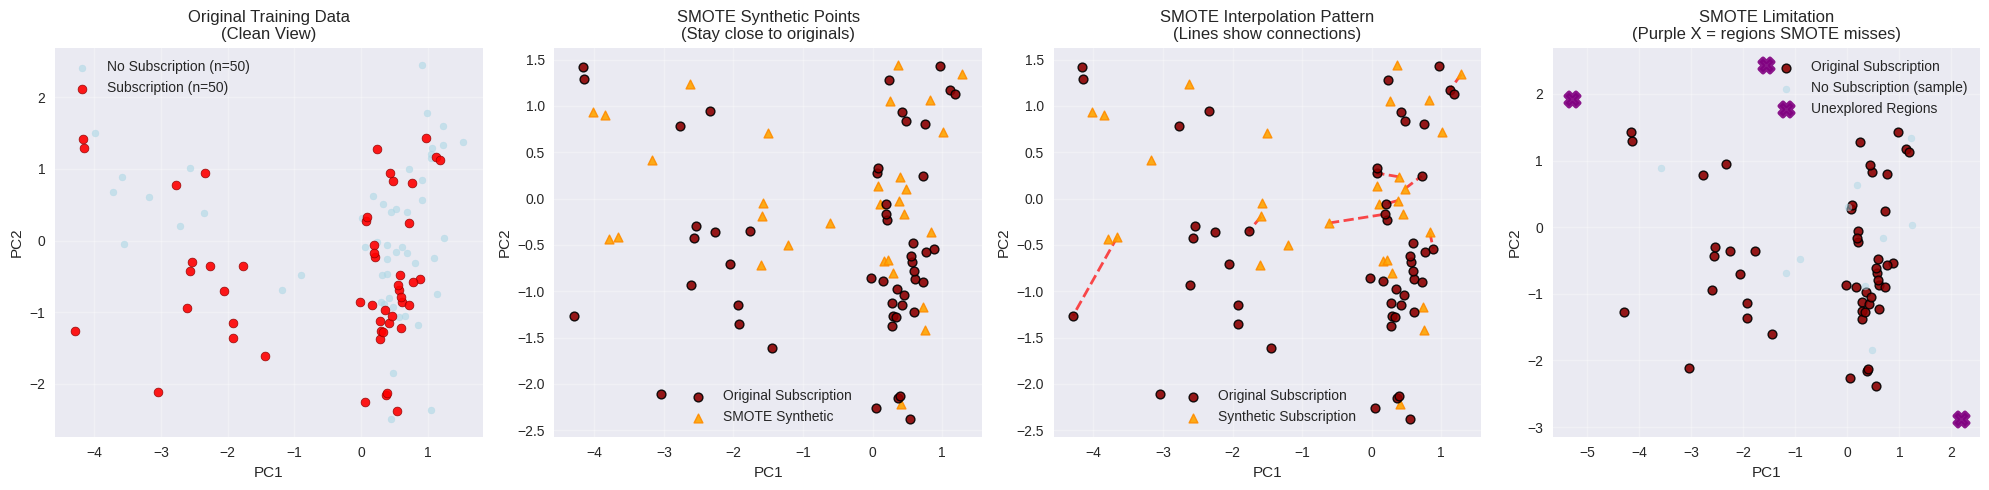

In [ ]:
# ===============================================
# CRITICAL VISUALIZATION: SMOTE INTERPOLATION PROBLEM
# ===============================================

print("\n=== THE SMOTE INTERPOLATION PROBLEM ===")
print("Let's see exactly what SMOTE does - and why it can be problematic")
print("Using focused visualization to clearly show the interpolation pattern...")

# Create a CLEANER, more focused visualization showing SMOTE's interpolation
# Use the same PCA transformation fitted earlier for consistency
X_sample_pca = pca.transform(X_smote_sample)
X_smote_pca = pca.transform(X_train_smote)

# Identify original vs synthetic points
n_original = len(X_smote_sample)
original_mask = np.arange(len(X_train_smote)) < n_original
synthetic_mask = ~original_mask

# Get subscription-only data for cleaner visualization
subscription_orig_mask = y_smote_sample == 1
subscription_orig_pca = X_sample_pca[subscription_orig_mask]

# Get synthetic subscription points
subscription_synth_mask = (y_train_smote[synthetic_mask] == 1)
synthetic_subscription_indices = np.where(synthetic_mask)[0][subscription_synth_mask]

# CRITICAL: Much more aggressive subsampling for truly clean visualization
np.random.seed(42)  # Consistent results

# Take very few normal points for context - just to show the background
normal_orig_mask = y_smote_sample == 0
normal_orig_pca = X_sample_pca[normal_orig_mask]
n_normal_show = min(50, len(normal_orig_pca))  # Very few normal points
normal_show_indices = np.random.choice(len(normal_orig_pca), n_normal_show, replace=False)
normal_show_pca = normal_orig_pca[normal_show_indices]

# Show fewer synthetic points but ensure pattern is visible
n_synth_show = min(30, len(synthetic_subscription_indices))  # Much fewer for clarity
synth_show_indices = np.random.choice(len(synthetic_subscription_indices), n_synth_show, replace=False)
synth_show_pca = X_smote_pca[synthetic_subscription_indices[synth_show_indices]]

# Also subsample original subscription points for cleaner view
n_orig_sub_show = min(50, len(subscription_orig_pca))  # Fewer original points too
orig_sub_indices = np.random.choice(len(subscription_orig_pca), n_orig_sub_show, replace=False)
subscription_show_pca = subscription_orig_pca[orig_sub_indices]

plt.figure(figsize=(20, 5))

# Plot 1: Clean original data with minimal points
plt.subplot(1, 4, 1)
plt.scatter(normal_show_pca[:, 0], normal_show_pca[:, 1],
           c='lightblue', alpha=0.6, s=25, label=f'No Subscription (n={n_normal_show})')
plt.scatter(subscription_show_pca[:, 0], subscription_show_pca[:, 1],
           c='red', alpha=0.9, s=40, label=f'Subscription (n={n_orig_sub_show})',
           edgecolors='darkred', linewidth=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Original Training Data\n(Clean View)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Show ONLY synthetic points with minimal original context
plt.subplot(1, 4, 2)
# Fewer original subscription points for reference
plt.scatter(subscription_show_pca[:, 0], subscription_show_pca[:, 1],
           c='darkred', alpha=0.9, s=40, label='Original Subscription',
           edgecolors='black', linewidth=1, zorder=3)
# Synthetic subscription points
plt.scatter(synth_show_pca[:, 0], synth_show_pca[:, 1],
           c='orange', alpha=0.9, s=40, marker='^', label='SMOTE Synthetic',
           edgecolors='darkorange', linewidth=1, zorder=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SMOTE Synthetic Points\n(Stay close to originals)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Show interpolation with VERY few clear lines
plt.subplot(1, 4, 3)
# Original subscription points
plt.scatter(subscription_show_pca[:, 0], subscription_show_pca[:, 1],
           c='darkred', alpha=0.9, s=40, label='Original Subscription',
           edgecolors='black', linewidth=1, zorder=3)
# Synthetic subscription points
plt.scatter(synth_show_pca[:, 0], synth_show_pca[:, 1],
           c='orange', alpha=0.9, s=40, marker='^', label='Synthetic Subscription',
           edgecolors='darkorange', linewidth=1, zorder=2)

# Draw only a few clear interpolation lines
from scipy.spatial.distance import cdist

if len(synth_show_pca) > 0 and len(subscription_show_pca) > 1:
    # Only show 8-10 lines maximum for clarity
    n_lines_show = min(8, len(synth_show_pca))
    synth_subset = synth_show_pca[:n_lines_show]

    distances = cdist(synth_subset, subscription_show_pca)
    for i, synth_point in enumerate(synth_subset):
        closest_orig_idx = np.argmin(distances[i])
        orig_point = subscription_show_pca[closest_orig_idx]
        plt.plot([synth_point[0], orig_point[0]], [synth_point[1], orig_point[1]],
                'red', alpha=0.7, linewidth=2, linestyle='--', zorder=1)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SMOTE Interpolation Pattern\n(Lines show connections)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Show unexplored regions more clearly
plt.subplot(1, 4, 4)
# Minimal original subscription points
plt.scatter(subscription_show_pca[:, 0], subscription_show_pca[:, 1],
           c='darkred', alpha=0.9, s=40, label='Original Subscription',
           edgecolors='black', linewidth=1)

# Just a few normal points for minimal context
plt.scatter(normal_show_pca[:10, 0], normal_show_pca[:10, 1],
           c='lightblue', alpha=0.5, s=25, label='No Subscription (sample)')

# Create fewer but more visible unexplored regions
subscription_x_range = [subscription_show_pca[:, 0].min(), subscription_show_pca[:, 0].max()]
subscription_y_range = [subscription_show_pca[:, 1].min(), subscription_show_pca[:, 1].max()]

# Place unexplored regions strategically
unexplored_x = [subscription_x_range[0] - 1, subscription_x_range[1] + 1,
                (subscription_x_range[0] + subscription_x_range[1]) / 2]
unexplored_y = [subscription_y_range[1] + 0.5, subscription_y_range[0] - 0.5,
                subscription_y_range[1] + 1]

plt.scatter(unexplored_x, unexplored_y,
           c='purple', alpha=0.9, s=100, marker='X', linewidth=3,
           label='Unexplored Regions')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SMOTE Limitation\n(Purple X = regions SMOTE misses)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Class Weights: XGBoost's Built-in Imbalance Solution

**The results we see:**
* **Predicted subscriptions (2,078):** This is 1,158 (false positives) + 920 (true positives) = 2,078 total predictions of "subscription"
* **Actually subscription (1,058):** This is 138 (false negatives) + 920 (true positives) = 1,058 people who actually subscribed
* **Actually NO subscription (7,985):** This is 6,827 (true negatives) + 1,158 (false positives) = 7,985 people who actually didn't subscribe

XGBoost's scale_pos_weight parameter (set to 7.5) tells the model to penalize missed subscriptions 7.5x more than wasted marketing:
- Highest recall: 87% (920 out of 1,058 subscribers caught)
- Low precision: 44.3% (aggressive predictions create marketing waste)
- F1-score: 58.7% (lower than SMOTE due to precision penalty)
- Requires contacting 2,078 customers vs baseline's 744

**What this means in business terms:**
* **Significantly more wasted marketing efforts**: The model predicted 2,078 customers would subscribe, but only 920 actually did. The other 1,158 customers received marketing calls but said "no" - that's 4.6x more waste than baseline (1,158 vs 254).
* **Fewest missed subscriptions**: Out of 1,058 customers who would actually subscribe, class weights identified 920 of them vs baseline's 490. Only 138 potential subscribers never got contacted.

**Class Weights vs Baseline comparison:**
- Finds 430 more subscribers (920 vs 490) - an 88% improvement
- But creates 904 more wasted marketing efforts (1,158 vs 254)
- Trade-off: For every additional subscriber found, class weights generates 2.1 extra wasted contacts

**Class Weights vs SMOTE comparison:**
- Finds 238 more subscribers than SMOTE (920 vs 682)
- But creates 629 more wasted efforts than SMOTE (1,158 vs 529)
- More aggressive approach: casts wider net to catch more subscribers

This approach maximizes subscription capture at the cost of marketing efficiency. Perfect for campaigns where subscriber lifetime value far exceeds marketing costs. No synthetic data complexity, just intelligent parameter tuning that makes the model much more aggressive in predicting subscriptions.

In [ ]:
# ===============================================
# PART 5: CLASS WEIGHTS APPROACH
# ===============================================

print("\n=== CLASS WEIGHTS APPROACH ===")

# Calculate optimal class weight
class_ratio = sum(y_train == 0) / sum(y_train == 1)
print(f"Class ratio (no subscription/subscription): {class_ratio:.1f}")

weighted_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=class_ratio,
    random_state=42,
    eval_metric='logloss',
    verbosity=0,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1
)

weighted_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_weighted = weighted_model.predict(X_test_scaled)
y_prob_weighted = weighted_model.predict_proba(X_test_scaled)[:, 1]

weighted_metrics = calculate_metrics(y_test, y_pred_weighted, y_prob_weighted, "Class Weighted")

print("Class Weighted Model Performance:")
for key, value in weighted_metrics.items():
    if key != 'Model':
        print(f"{key.replace('_', ' ')}: {value:.4f}")

cm_weighted = confusion_matrix(y_test, y_pred_weighted)
print(f"\nConfusion Matrix:")
print(cm_weighted)

tn, fp, fn, tp = cm_weighted.ravel()
print(f"\nBusiness Impact:")
print(f"Missed Subscriptions: {fn}, Wasted Marketing: {fp}, Correctly Targeted: {tp}")


=== CLASS WEIGHTS APPROACH ===
Class ratio (no subscription/subscription): 7.5
Class Weighted Model Performance:
Precision: 0.4427
Recall: 0.8696
F1 Score: 0.5867
ROC AUC: 0.9291
PR AUC: 0.6145
Balanced Accuracy: 0.8623

Confusion Matrix:
[[6827 1158]
 [ 138  920]]

Business Impact:
Missed Subscriptions: 138, Wasted Marketing: 1158, Correctly Targeted: 920


### Threshold Tuning: Simple Optimization, Outstanding Results

Basically, we will find the threshold that gives the maximum F1-score and set it as the optimal threshold. Because F1-score balances precision and recall, making it a good general-purpose optimization target. We could optimize for other metrics. For example, Maximize recall (if missing positives is very costly), Maximize precision (if false positives are very costly), Minimize business cost (as we will do in the next approach)

**The results we see:**
* **Predicted subscriptions (1,479):** This is 672 (false positives) + 807 (true positives) = 1,479 total predictions of "subscription"
* **Actually subscription (1,058):** This is 251 (false negatives) + 807 (true positives) = 1,058 people who actually subscribed
* **Actually NO subscription (7,985):** This is 7,313 (true negatives) + 672 (false positives) = 7,985 people who actually didn't subscribe

Instead of default 0.5 threshold, optimizing for F1-score finds 0.261 works much better:
- Best F1-score: 63.6% (17% improvement over baseline)
- Balanced performance: 54.6% precision, 76.3% recall
- Uses original model, just optimizes decision boundary
- Requires contacting 1,479 customers vs baseline's 744

**What this means in business terms:**
* **Moderate wasted marketing efforts**: The model predicted 1,479 customers would subscribe, but only 807 actually did. The other 672 customers received marketing calls but said "no" - that's 2.6x more waste than baseline (672 vs 254) but much less than class weights.
* **Well-balanced missed subscriptions**: Out of 1,058 customers who would actually subscribe, threshold tuning identified 807 of them vs baseline's 490. Only 251 potential subscribers never got contacted.

**Threshold Tuning vs Other Methods:**
- **vs Baseline**: Finds 317 more subscribers (807 vs 490) with 418 more wasted efforts (672 vs 254)
- **vs SMOTE**: Finds 125 more subscribers (807 vs 682) with 143 more wasted efforts (672 vs 529)  
- **vs Class Weights**: Finds 113 fewer subscribers (807 vs 920) but 486 fewer wasted efforts (672 vs 1,158)

**Trade-off ratio**: For every additional subscriber found vs baseline, threshold tuning generates 1.3 extra wasted contacts - the most efficient improvement.

Why this works so well:
- Leverages model's probability estimates more effectively
- No training data modification required
- Computationally trivial compared to SMOTE
- Easily interpretable and adjustable for business needs

This demonstrates the power of proper threshold optimization - achieves the best balance between finding subscribers and controlling marketing waste with minimal effort.

In [ ]:
# ===============================================
# PART 6: THRESHOLD TUNING
# ===============================================

print("\n=== THRESHOLD TUNING APPROACH ===")

# Find optimal threshold using baseline model probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_baseline)

# Calculate F1 scores for each threshold
f1_scores = []
for p, r in zip(precision, recall):
    if p + r == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(2 * (p * r) / (p + r))

f1_scores = np.array(f1_scores)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"Optimal threshold: {optimal_threshold:.3f} (default: 0.5)")
print(f"Expected F1 improvement: {f1_scores[optimal_idx]:.3f}")

# Apply optimal threshold
y_pred_threshold = (y_prob_baseline >= optimal_threshold).astype(int)

threshold_metrics = calculate_metrics(y_test, y_pred_threshold, y_prob_baseline, "Threshold Tuned")

print("\nThreshold Tuned Performance:")
for key, value in threshold_metrics.items():
    if key != 'Model':
        print(f"{key.replace('_', ' ')}: {value:.4f}")

cm_threshold = confusion_matrix(y_test, y_pred_threshold)
print(f"\nConfusion Matrix:")
print(cm_threshold)

tn, fp, fn, tp = cm_threshold.ravel()
print(f"\nBusiness Impact:")
print(f"Missed Subscriptions: {fn}, Wasted Marketing: {fp}, Correctly Targeted: {tp}")


=== THRESHOLD TUNING APPROACH ===
Optimal threshold: 0.261 (default: 0.5)
Expected F1 improvement: 0.636

Threshold Tuned Performance:
Precision: 0.5456
Recall: 0.7628
F1 Score: 0.6362
ROC AUC: 0.9309
PR AUC: 0.6216
Balanced Accuracy: 0.8393

Confusion Matrix:
[[7313  672]
 [ 251  807]]

Business Impact:
Missed Subscriptions: 251, Wasted Marketing: 672, Correctly Targeted: 807


### Cost-Sensitive Optimization: Business-First Decision Making

**What This Approach Does:**
Instead of optimizing for statistical metrics like F1-score, this method optimizes for actual business costs:
- Missing a potential subscriber: \$200 lost lifetime value
- Wasted marketing contact: \$10 cost per call/email

The algorithm tests different thresholds and picks the one that minimizes total business cost, not statistical performance. This represents real-world decision making where business outcomes matter more than academic metrics.

**Note:** ALways try to come up with realiztic estimates. In this case, I assumed a small deposit of average \$5,000 at 2% bank spread (profit) over 2 years = $200 profit.

**The results we see:**
* **Predicted subscriptions (2,897):** This is 1,897 (false positives) + 1,000 (true positives) = 2,897 total predictions of "subscription"
* **Actually subscription (1,058):** This is 58 (false negatives) + 1,000 (true positives) = 1,058 people who actually subscribed
* **Actually NO subscription (7,985):** This is 6,088 (true negatives) + 1,897 (false positives) = 7,985 people who actually didn't subscribe

Cost-sensitive optimization finds threshold 0.250 delivers lowest total business cost:
- Highest recall: 94.5% (1,000 out of 1,058 subscribers found)
- Lowest precision: 34.5% (very aggressive predictions)
- Lowest total cost: \$30,570 vs baseline's \$116,140
- Requires contacting 2,897 customers - nearly one-third of the entire test set

**What this means in business terms:**
* **Maximum wasted marketing efforts**: The model predicted 2,897 customers would subscribe, but only 1,000 actually did. The other 1,897 customers received marketing calls but said "no" - that's 7.5x more waste than baseline (1,897 vs 254).
* **Minimal missed subscriptions**: Out of 1,058 customers who would actually subscribe, this approach identified 1,000 of them. Only 58 potential subscribers never got contacted - the best performance.

**Cost-Sensitive vs Other Methods:**
- **vs Baseline**: Finds 510 more subscribers (1,000 vs 490) but creates 1,643 more wasted efforts (1,897 vs 254)
- **vs SMOTE**: Finds 318 more subscribers (1,000 vs 682) but creates 1,368 more wasted efforts (1,897 vs 529)
- **vs Threshold Tuning**: Finds 193 more subscribers (1,000 vs 807) but creates 1,225 more wasted efforts (1,897 vs 672)
- **vs Class Weights**: Finds 80 more subscribers (1,000 vs 920) but creates 739 more wasted efforts (1,897 vs 1,158)

**Business Cost Breakdown:**
- Lost revenue from 58 missed subscriptions: \$11,600
- Marketing costs for 1,897 uninterested contacts: \$18,970
- Total cost: \$30,570 (vs baseline's $116,140)

This extreme approach maximizes revenue capture but floods marketing teams with leads. Perfect for high-value subscription scenarios where the cost of missing customers far exceeds marketing inefficiency. However, it requires significant marketing capacity to handle the volume of contacts.

In [ ]:
# ===============================================
# PART 7: COST-SENSITIVE THRESHOLD
# We test different threshold values (0.1, 0.15, 0.2, etc. up to 0.9) and for each one,
# calculate the total business cost using our formula: (missed subscriptions × $200) + (wasted marketing × $10).
# The algorithm picks whichever threshold gives us the lowest total dollar cost, not the best statistical score.
# ===============================================

print("\n=== COST-SENSITIVE THRESHOLD OPTIMIZATION ===")

# In bank marketing: Missing potential subscriber = $200 lost lifetime value, Marketing to non-subscriber = $10 cost
cost_fn = 200  # Cost of missing a potential subscriber (lost lifetime value)
cost_fp = 10   # Cost of marketing to someone who won't subscribe

# Find threshold that minimizes total cost
thresholds_test = np.arange(0.1, 0.9, 0.05)
costs = []

for thresh in thresholds_test:
    y_pred_temp = (y_prob_weighted >= thresh).astype(int)  # Use weighted model
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = fn * cost_fn + fp * cost_fp
    costs.append(total_cost)

optimal_cost_idx = np.argmin(costs)
optimal_cost_threshold = thresholds_test[optimal_cost_idx]

print(f"Cost-optimal threshold: {optimal_cost_threshold:.3f}")
print(f"Minimum total cost: ${costs[optimal_cost_idx]:,}")

y_pred_cost = (y_prob_weighted >= optimal_cost_threshold).astype(int)
cost_metrics = calculate_metrics(y_test, y_pred_cost, y_prob_weighted, "Cost-Optimized")

print("\nCost-Optimized Performance:")
for key, value in cost_metrics.items():
    if key != 'Model':
        print(f"{key.replace('_', ' ')}: {value:.4f}")

cm_cost = confusion_matrix(y_test, y_pred_cost)
tn, fp, fn, tp = cm_cost.ravel()
print(f"\nBusiness Impact:")
print(f"Missed Subscriptions: {fn} (${fn * cost_fn:,} lost revenue)")
print(f"Wasted Marketing: {fp} (${fp * cost_fp:,} cost)")
print(f"Total Cost: ${fn * cost_fn + fp * cost_fp:,}")


=== COST-SENSITIVE THRESHOLD OPTIMIZATION ===
Cost-optimal threshold: 0.250
Minimum total cost: $30,570

Cost-Optimized Performance:
Precision: 0.3452
Recall: 0.9452
F1 Score: 0.5057
ROC AUC: 0.9291
PR AUC: 0.6145
Balanced Accuracy: 0.8538

Business Impact:
Missed Subscriptions: 58 ($11,600 lost revenue)
Wasted Marketing: 1897 ($18,970 cost)
Total Cost: $30,570


### Business Cost Comparison Across All Approaches

**Cost Assumptions (hypothetical for demonstration):**
- Missing a potential subscriber: \$200 lost lifetime value
- Wasted marketing contact: \$10 cost per call/email


| Approach | Missed Subscriptions | Lost Revenue | Wasted Marketing | Marketing Cost | Total Cost | Subscribers Found | Detection Rate |
|----------|---------------------|--------------|------------------|----------------|------------|-------------------|----------------|
| Baseline | 568 | \$113,600 | 254 | \$2,540 | \$116,140 | 490 | 46.3% |
| SMOTE | 376 | \$75,200 | 529 | $5,290 | \$80,490 | 682 | 64.5% |
| Class Weighted | 138 | \$27,600 | 1,158 | \$11,580 | \$39,180 | 920 | 87.0% |
| Threshold Tuned | 251 | \$50,200 | 672 | \$6,720 | \$56,920 | 807 | 76.3% |
| Cost-Optimized | 58 | \$11,600 | 1,897 | \$18,970 | \$30,570 | 1,000 | 94.5% |

**Key Business Insights:**

**Lowest Total Cost:** Cost-Optimized ($30,570) - despite highest marketing waste, minimizes expensive missed subscriptions

**Highest Total Cost:** Baseline ($116,140) - conservative approach costs the most due to massive revenue loss

**Best Detection Rate:** Cost-Optimized (94.5%) - finds nearly all potential subscribers

**Cost Savings:** Cost-Optimized saves \$85,570 compared to Baseline approach

**The Business Logic:**
- Missing a subscriber costs \$200 (lifetime value)
- Wasted marketing contact costs \$10 (call/email expense)  
- Therefore, it's better to waste 10 marketing contacts than miss 1 subscriber

**Strategic Implications:**
- **High-value subscriptions:** Use Cost-Optimized (lowest total cost)
- **Limited marketing capacity:** Use Threshold Tuned (best balance)
- **Risk-averse campaigns:** Use SMOTE (moderate approach)
- **Avoid:** Baseline approach (highest cost due to missed revenue)

This table demonstrates why business-focused optimization outperforms statistical metrics - the approach with the lowest F1-score (Cost-Optimized) delivers the best business outcome by understanding the true cost structure.